# BINF GU 4002: Machine Learning for Healthcare, Spring 2025
# Assignment \#3: Multilayer Perceptrons and Classification with Electronic Health Record Data

This assignment covers two separate but significant tasks in modern clinical informatics: 1) deep learning and 2) classification with electronic health record (EHR) data.

For the first part of the assignment, you will be implementing multilayer perceptrons with gradient descent. The exercise is to understand when (and why) the "deep" part of deep learning is necessary with a classic problem in machine learning.

The second part of the assignment is on a classic task in machine learning for healthcare: predicting in hospital mortality for patients in acute care settings.

**You will need access to [MIMIC IV version 3.1](https://physionet.org/content/mimiciv/3.1/) for this assignment!**

**<font color="red">Please make sure that your Notebook runs (no running cells out of order!) and that your written answers are formatted using </font>$\LaTeX$<font color="red"> in `markdown` cells.</font>**

**<font color="red">When submitting, please name your files `{UNI}_binf4002_mlh_assignment_3.{filetype}` and submit both a `.ipynb` and `.html` version of your Jupyter notebook.</font>**

#### Best of Luck!

In [1]:
import numpy as np
np.random.seed(0)
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedGroupKFold, RandomizedSearchCV, train_test_split
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, average_precision_score, accuracy_score, recall_score, precision_score, f1_score

from tqdm import tqdm

## [50 Points] Question 1: Implement a Multilayer Perceptron with Gradient Descent on Noisy XOR Data

We will be implementing and training multilayer perceptrons as an exercise to explore why deep learning is useful.

Our data will be generated in part using the XOR ("exclusive or") operator, denoted as $P\oplus{Q}$, is a [logical operator](https://en.wikipedia.org/wiki/Logical_connective) with the following truth table:

| $P$ | $Q$ |  $P\oplus{Q}$|
| :-: | :-: | :-: |
| 1 | 1 | 0 |
| 1 | 0 | 1 |
| 0 | 1 | 1 |
| 0 | 0 | 0 |

We have generated the noisy version of XOR for you.

In [2]:
def generate_noisy_xor_data(sep = 0.1, n_samples = 1000) :

    X, y = [], []
    for x0, x1 in [(0,0), (0,1), (1,0), (1,1)] :

        current_sample_size = n_samples // 4
        X.append(np.vstack([np.random.normal(x0, sep, size = current_sample_size), np.random.normal(x1, sep, size = current_sample_size)]).T)
        y.append([np.logical_xor(x0,x1).astype(int)] * current_sample_size)
        
    X = np.vstack(X)
    y = np.hstack(y)
    # y = np.expand_dims(np.hstack(y), axis = -1)

    return X, y

X, y = generate_noisy_xor_data(n_samples = 2000, sep = 0.1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.1)

print(f'{X_train.shape=}, {X_val.shape=} {X_test.shape=}')

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test = scaler.transform(X_test)

X_train.shape=(1440, 2), X_val.shape=(160, 2) X_test.shape=(400, 2)



#### [10 Points] 1.1: Interpret the figure with the decision boundary below (`Figure for Question 1.1`). Make sure to discuss what model was used (look at the code block), whether you think this is a good model (and why), and what the decision boundary shows us.

In [3]:
def plot_decision_boundary(model):   
    # Get arrays for plotting
    X_for_decision_boundary = np.vstack(np.meshgrid(np.arange(-0.5, 1.51, 0.02), np.arange(-0.5, 1.51, 0.02))).reshape(2, -1).T
    X_for_decision_boundary_scaled = scaler.transform(X_for_decision_boundary)

    X_val_preds = model.predict(X_val_scaled)
    X_val_pred_colors = np.array(['tab:orange' if e == 0 else 'tab:blue' for e in X_val_preds])
    X_for_decision_boundary_preds = model.predict(X_for_decision_boundary_scaled)
    X_for_decision_boundary_colors = np.array(['tab:orange' if e == 0 else 'tab:blue' for e in X_for_decision_boundary_preds])

    # Plot
    fig, ax = plt.subplots(1,3, figsize = (15,5))

    ax = ax.flatten()

    ax[0].scatter(X_val[y_val == 0][:,0],X_val[y_val==0][:,1], color = 'tab:orange', marker = 'o', facecolor = 'None', label = 'Label 0')
    ax[0].scatter(X_val[y_val == 1][:,0],X_val[y_val==1][:,1], color = 'tab:blue', marker = 'x', label = 'Label 1')
    ax[0].set_title('Ground Truth Validation Data')
    ax[0].legend()

    ax[1].scatter(X_val[y_val == 0][:,0],X_val[y_val==0][:,1], color = X_val_pred_colors[y_val == 0], marker = 'o', facecolor = 'None')
    ax[1].scatter(X_val[y_val == 1][:,0],X_val[y_val==1][:,1], color = X_val_pred_colors[y_val == 1], marker = 'x')
    ax[1].set_title('Predicted Labels for Validation Data')

    ax[2].scatter(X_for_decision_boundary[:,0],X_for_decision_boundary[:,1], color = X_for_decision_boundary_colors)
    ax[2].scatter(X_val[y_val == 0][:,0],X_val[y_val==0][:,1], color = 'black', marker = 'o', facecolor = 'None')
    ax[2].scatter(X_val[y_val == 1][:,0],X_val[y_val==1][:,1], color = 'black', marker = 'x')
    ax[2].set_title('Decision Boundaries')

    for i in range(3) :
        
        ax[i].set_xlim(-0.5, 1.5)
        ax[i].set_ylim(-0.5, 1.5)

    fig.suptitle('Figure for Question 1.1', fontweight = 'bold')

    plt.show()
    plt.close()

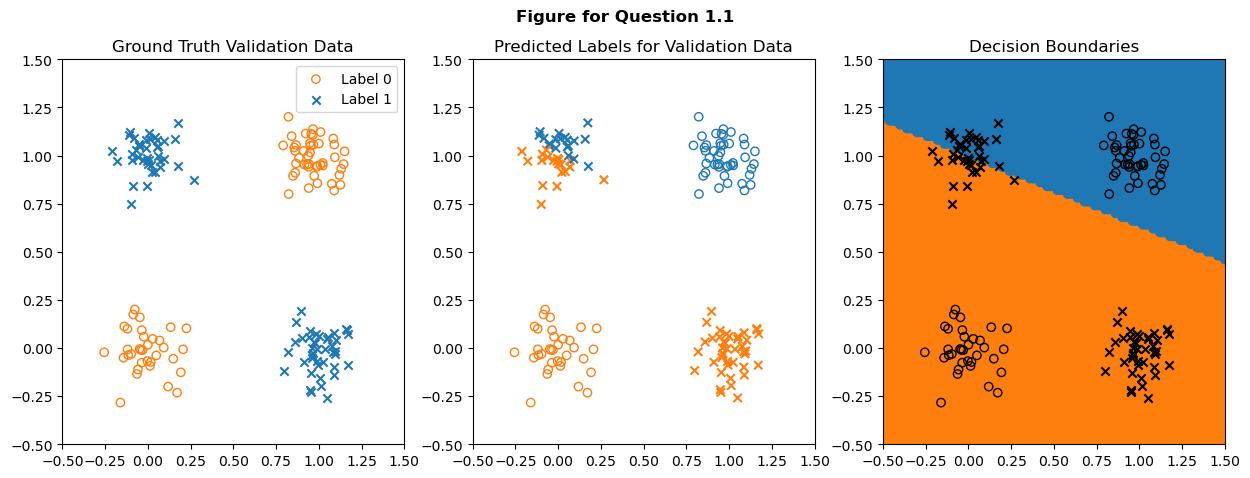

In [4]:
# CODE BLOCK FOR QUESTION 1.1

# Train model
lr = LogisticRegression()
lr.fit(X_train, y_train)

plot_decision_boundary(lr)

<font color="red">Answer 1.1</font>

Here we are using the logistic regression as the predictor, which can only generate the linear decision boundary. We can imagine that though logistic regression is giving a non-linear predicted "probability" $\sigma(w^Tx)$, if we use a threshold (say, 0.5) to give a predicted label, our decision rule is equivalent to

$$
\hat{y} =
\begin{cases}
&1 & w^Tx \ge 0 \\
&0 & w^Tx < 0
\end{cases}
$$

which is effectively a linear decision boundary.

However, in this case, the label is linearly inseparable, making the logistic regression a failure. We can observe that the model is predicting more than half of the points wrong.

#### [30 Points] 1.2: Implement a Multilayer Perceptron model with the skeleton code below. Use only base `numpy`.

We are implementing a feedforward neural network with:

- Two hidden layers with [ReLU](https://en.wikipedia.org/wiki/Rectifier_(neural_networks)) activation.
    - Think about the shape of the weight matrices. Your `MLP` class takes in `input_dims`, `hidden_dims`, and `output_dims` as parameters. What dimensions should weights `W1` and `W2` and biases `b1` and `b1` have?
    - Do not zero intialize your weights. Read the Wikipedia article on [Weight Initialization](https://en.wikipedia.org/wiki/Weight_initialization) if you want details on why.
- The MLP is for a binary classification task
    - Think about whether the output layer need an activation function and if it does what activation function that might be.
- We will use a vanilla gradient update.

**If you feel particularly lost, refer to the Stanford CS231N notes on the MLP classifier ([1](https://cs231n.github.io/neural-networks-1/), [2](https://cs231n.github.io/optimization-2/), [3](https://cs231n.github.io/neural-networks-3/), [4](https://cs231n.github.io/neural-networks-case-study/)) or the [*Dive into Deep Learning*](https://d2l.ai/chapter_multilayer-perceptrons/index.html) chapter on MLPs.**

![MLP](./MLP.jpg)

In [5]:
# QUESTION 1.2

class MLP:

    def __init__(self, input_dims = 2, hidden_dims = 10, output_dims = 1):

        # Initialize the weights and biases for the two layers
        self.input_dims = input_dims
        self.hidden_dims = hidden_dims
        self.output_dims = output_dims
    
        # Be conscious of what the dimensions of each W and b are with respect to input_dims, hidden_dims, and output_dims.
        # Do not initialize W with np.zeros (i.e. zero intialization). Read this for more information: https://en.wikipedia.org/wiki/Weight_initialization
        # An easy intialization is 0.01 * np.random.randn()
        # Sidebar: intitialization of neural networks was a big issue back in the aughts. Look up Kaiming / He and Xavier / Glorot initialization for landmark papers.
        self.W1 = 0.01 * np.random.randn(input_dims, hidden_dims)
        self.b1 = np.zeros(hidden_dims)
        self.W2 = 0.01 * np.random.randn(hidden_dims, output_dims)
        self.b2 = np.zeros(output_dims)

    def relu(self, X):
        # relu(X) = X if X > 0 else 0
        return np.maximum(X, 0)
    
    def relu_derivative(self, X):
        # if X > 0 return 1 else 0
        return (X > 0).astype(int)
    
    def sigmoid(self, X):
        # sigma(x) = 1 / (1 + np.exp(X))
        return 1 / (1 + np.exp(-X))
    
    # def sigmoid_derivative(self, X) :
    #     # d/dx sigma(x) = sigma(x) * (1 - sigma(x))
    #     # TO-DO
    #     return None

    def forward_and_backward(self, X, y):
        # Forward pass of input
        # https://d2l.ai/chapter_multilayer-perceptrons/backprop.html#forward-propagation

        z1 = X @ self.W1 + self.b1
        a1 = self.relu(z1)
        z2 = a1 @ self.W2 + self.b2
        a2 = self.sigmoid(z2)

        loss = -np.mean(y * np.log(a2) + (1 - y) * np.log(1 - a2))

        # Backward pass
        dldz2 = a2 - y
        dldw2 = a1.T @ dldz2
        dldb2 = np.sum(dldz2, axis=0)

        dldz1 = (dldz2 @ self.W2.T) * self.relu_derivative(z1)
        dldw1 = X.T @ dldz1
        dldb1 = np.sum(dldz1, axis=0)
        

        return {"dldw1": dldw1, "dldw2": dldw2, "dldb1": dldb1, "dldb2": dldb2, "loss": loss}


    def fit(self, X, Y, epochs, learning_rate):
        # Call forward and backward in each epoch
        if len(Y.shape) == 1:
            Y = Y.reshape(-1, 1)
            
        # TO-DO
        losses = []
        for epoch in range(epochs):
            gradient = self.forward_and_backward(X,Y)
            dldw1 = gradient["dldw1"]
            dldw2 = gradient["dldw2"]
            dldb1 = gradient["dldb1"]
            dldb2 = gradient["dldb2"]
            loss = gradient["loss"]

            # gradient descent
            self.W1 -= learning_rate * dldw1
            self.W2 -= learning_rate * dldw2
            self.b1 -= learning_rate * dldb1
            self.b2 -= learning_rate * dldb2

            losses.append(loss)

        return losses

    def predict(self, X, threshold = 0.5):
        
        # TO-DO
        z1 = X @ self.W1 + self.b1
        a1 = self.relu(z1)
        z2 = a1 @ self.W2 + self.b2
        a2 = self.sigmoid(z2)

        return (a2 > threshold).astype(int)

#### [10 Points] 1.3: Train your MLP model using the Noisy XOR data with `hidden_dims=20` and `epochs=500`. Recreate the Plot from Question 1.1 with your model. Interpret your results--how is the decision boundary different than in 1.2? (Feel free to use the code block from 1.1).

#### You are allowed to reference the following materials:
- All course notes from our course.
- The [Wikipedia article on MLPs](https://en.wikipedia.org/wiki/Multilayer_perceptron).
- The [*Dive into Deep Learning*](https://d2l.ai/chapter_multilayer-perceptrons/index.html) chapter on MLPs.
- Course notes from [Module 1: Neural Networks](https://cs231n.github.io/) from CS231N Convolutional Neural Networks for Visual Recognition at Stanford University.
- The [`scikit-learn`](https://scikit-learn.org/stable/modules/neural_networks_supervised.html) documentation on MLPs (do **not** use any package other than `numpy` for question 1.3).

In [6]:
model = MLP(input_dims=X.shape[1], hidden_dims=20, output_dims=1)
losses = model.fit(X_train, y_train, epochs=500, learning_rate=1e-3)

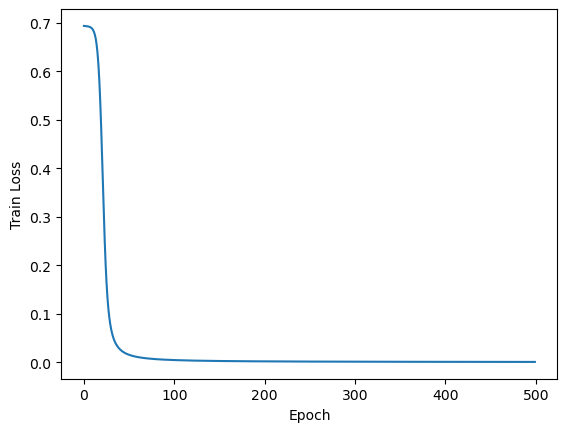

In [7]:
plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("Train Loss")
plt.show()

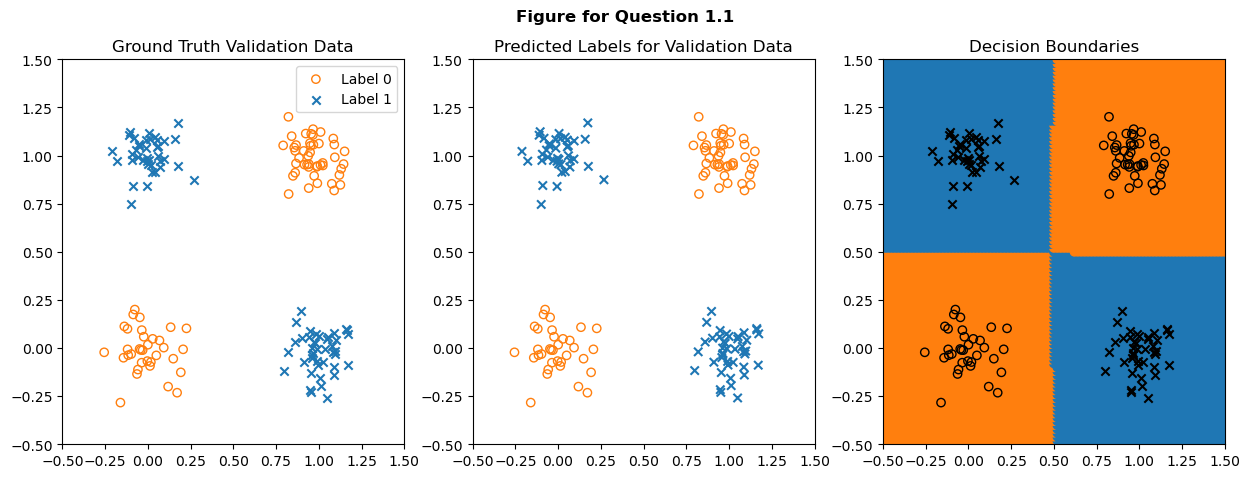

In [8]:
plot_decision_boundary(model)

<font color="red">Answer 1.3</font>

Now the decision boundary is apparently different from what we observed in logistic regression. Now the decision boundary is not a linear boundary. This non-linearity comes from our non-linear activation function ReLU.

# [50 Points] Question 2: Classification of Adverse Patient Events with Electronic Health Record Data

Inclusion criteria
- All subjects who have a length of stay greater or equal to 24 hours.
- Subjects who were admitted in an urgent care setting (see [this conversation](https://github.com/MIT-LCP/mimic-code/discussions/1215)).

This is intentionally an open-ended problem. We want to challenge you--there is no single correct approach to solve this problem. Feel free to flex your creativity in leveraging the different things you've learned in this class.

EHR-based classification of adverse events is an entire research field of itself. This *Nature Protocols* paper from 2021 ["Use of deep learning to develop continuous-risk models for adverse event prediction from electronic health records"](https://www.nature.com/articles/s41596-021-00513-5) by Tomašev et al. is a good step-by-step overview of the challenges associated with this space.


**Instructor Note: I did all of the data extraction and manipulation with `Python` and `Pandas`. If you prefer to use `SQL` for this step, please feel free to do so! (Just make sure to show your work).**

#### [20 Points] Question 2.1: Generate Feature Vectors and Labels from MIMIC-IV for In-Hospital Mortality Prediction

At **minimum**, you should:
- Generate in-hospital mortality labels.
- Use inclusion and exclusion criteria to select the appropriate visits.
- Think critically about what features may be useful.
- Create feature vectors representing visits.
- Deal with missingness and outliers. Think about [imputation](https://scikit-learn.org/stable/modules/impute.html) and how to [detect / handle outlier values](https://online.stat.psu.edu/stat200/lesson/3/3.2) (note that these are examples, feel free to explore other methods).
- Consider how to deal with repeated measures.
- Take steps to prevent data leakage with good empirical practices.

`MIMIC-IV` contains several tables. I suggest starting `patients` and `admissions` under the `hosp` folder. Think about the different unique identifiers (UIDs)--`subject_id`,	`hadm_id`--and how to generate visit-based features while stratifying across subjects (patients).

In [2]:
patient = pd.read_csv("./data/hosp/patients.csv.gz")
admission = pd.read_csv("./data/hosp/admissions.csv.gz")

In [3]:
admission.head()

,subject_id,hadm_id,admittime,dischtime,deathtime,admission_type,admit_provider_id,admission_location,discharge_location,insurance,language,marital_status,race,edregtime,edouttime,hospital_expire_flag
0,10000032,22595853,2180-05-06 22:23:00,2180-05-07 17:15:00,NaN,URGENT,P49AFC,TRANSFER FROM HOSPITAL,HOME,Medicaid,English,WIDOWED,WHITE,2180-05-06 19:17:00,2180-05-06 23:30:00,0
1,10000032,22841357,2180-06-26 18:27:00,2180-06-27 18:49:00,NaN,EW EMER.,P784FA,EMERGENCY ROOM,HOME,Medicaid,English,WIDOWED,WHITE,2180-06-26 15:54:00,2180-06-26 21:31:00,0
2,10000032,25742920,2180-08-05 23:44:00,2180-08-07 17:50:00,NaN,EW EMER.,P19UTS,EMERGENCY ROOM,HOSPICE,Medicaid,English,WIDOWED,WHITE,2180-08-05 20:58:00,2180-08-06 01:44:00,0
3,10000032,29079034,2180-07-23 12:35:00,2180-07-25 17:55:00,NaN,EW EMER.,P06OTX,EMERGENCY ROOM,HOME,Medicaid,English,WIDOWED,WHITE,2180-07-23 05:54:00,2180-07-23 14:00:00,0
4,10000068,25022803,2160-03-03 23:16:00,2160-03-04 06:26:00,NaN,EU OBSERVATION,P39NWO,EMERGENCY ROOM,NaN,NaN,English,SINGLE,WHITE,2160-03-03 21:55:00,2160-03-04 06:26:00,0


In [4]:
len(admission)

546028

In [5]:
patient.head()

,subject_id,gender,anchor_age,anchor_year,anchor_year_group,dod
0,10000032,F,52,2180,2014 - 2016,2180-09-09
1,10000048,F,23,2126,2008 - 2010,NaN
2,10000058,F,33,2168,2020 - 2022,NaN
3,10000068,F,19,2160,2008 - 2010,NaN
4,10000084,M,72,2160,2017 - 2019,2161-02-13


In [6]:
len(patient)

364627

##### Inclusion 1: Urgent care setting

In [7]:
admission["admission_type"].unique()

array(['URGENT', 'EW EMER.', 'EU OBSERVATION', 'OBSERVATION ADMIT',
       'SURGICAL SAME DAY ADMISSION', 'AMBULATORY OBSERVATION',
       'DIRECT EMER.', 'DIRECT OBSERVATION', 'ELECTIVE'], dtype=object)

In [8]:
admission[admission["admission_type"].isna()]

,subject_id,hadm_id,admittime,dischtime,deathtime,admission_type,admit_provider_id,admission_location,discharge_location,insurance,language,marital_status,race,edregtime,edouttime,hospital_expire_flag


In [9]:
tmp = {
    "Emergency": ['AMBULATORY OBSERVATION', 'DIRECT EMER.', 'URGENT', 'EW EMER.', 'DIRECT OBSERVATION', 'EU OBSERVATION', 'OBSERVATION ADMIT'],
    "Elective": ['ELECTIVE', 'SURGICAL SAME DAY ADMISSION']
}
emergency_state = {}
for k, v in tmp.items():
    for i in v:
        emergency_state[i] = k
data = admission.copy()
data["emergency_state"] = data["admission_type"].map(emergency_state)
data = data[data["emergency_state"] == "Emergency"]

In [10]:
len(data)

490000

##### Inclusion 2: Length of stay

In [11]:
admission[admission["admittime"].isna()]

,subject_id,hadm_id,admittime,dischtime,deathtime,admission_type,admit_provider_id,admission_location,discharge_location,insurance,language,marital_status,race,edregtime,edouttime,hospital_expire_flag


In [12]:
admission[admission["dischtime"].isna()]

,subject_id,hadm_id,admittime,dischtime,deathtime,admission_type,admit_provider_id,admission_location,discharge_location,insurance,language,marital_status,race,edregtime,edouttime,hospital_expire_flag


here we can find some of the `dischtime` and `deathtime` are inconsistent and some of the time seems to be strange (eg. `00:00`). To calculate the stay of length, if we both have `dischtime` and `deathtime`, we choose the longer time as the length. (Since all these visits are considered as `hospital_expire_flag = 1`, we consider until they passed away they were still in the hospital)

In [13]:
data.loc[~data["deathtime"].isna() & (data["dischtime"] != data["deathtime"]),["admittime", "dischtime", "deathtime", "hospital_expire_flag"]]

,admittime,dischtime,deathtime,hospital_expire_flag
121,2131-03-09 20:33:00,2131-03-10 01:55:00,2131-03-10 21:53:00,1
454,2146-06-10 16:37:00,2146-07-12 00:00:00,2146-07-12 20:50:00,1
561,2124-11-14 15:41:00,2124-11-27 00:00:00,2124-11-27 21:21:00,1
1250,2175-07-06 15:57:00,2175-07-20 00:00:00,2175-07-20 22:50:00,1
1913,2165-08-13 14:00:00,2165-08-13 00:00:00,2165-08-13 22:20:00,1
...,...,...,...,...
544111,2125-09-25 19:12:00,2125-09-30 00:00:00,2125-09-30 22:45:00,1
544687,2153-06-01 20:14:00,2153-06-06 00:00:00,2153-06-06 23:26:00,1
545018,2152-01-20 20:03:00,2152-01-21 02:40:00,2152-01-21 20:03:00,1
545606,2152-07-17 08:03:00,2152-07-24 02:56:00,2152-07-24 22:45:00,1


In [14]:
data.loc[~data["deathtime"].isna() & (data["dischtime"] != data["deathtime"]) & (data["hospital_expire_flag"] != 1),["admittime", "dischtime", "deathtime", "hospital_expire_flag"]]

,admittime,dischtime,deathtime,hospital_expire_flag


In [15]:
data["stay_length"] = pd.DataFrame({"1":(pd.to_datetime(data["deathtime"])- pd.to_datetime(data["admittime"])).dt.total_seconds() / 3600.0, "2":(pd.to_datetime(data["dischtime"]) - pd.to_datetime(data["admittime"])).dt.total_seconds() / 3600.0}).max(axis=1)

In [16]:
data = data[data["stay_length"] >= 24]

In [17]:
len(data)

371342

##### Label: in-hospital mortality

In [18]:
admission["hospital_expire_flag"].unique()

array([0, 1])

In [19]:
admission[admission["hospital_expire_flag"].isna()]

,subject_id,hadm_id,admittime,dischtime,deathtime,admission_type,admit_provider_id,admission_location,discharge_location,insurance,language,marital_status,race,edregtime,edouttime,hospital_expire_flag


check consistency: if `hospital_expire_flag = 1`, then should have deathtime. If not having deathtime, then at least the `dod` should be consistent (then we can regard the `deathtime` is somehow missed and we can use `dischtime` to impute the `deathtime`)

In [20]:
data[data["deathtime"].isna() & (data["hospital_expire_flag"] == 1)].merge(patient, on="subject_id", how="left")[["dischtime", "deathtime", "dod"]]

,dischtime,deathtime,dod
0,2176-04-24 20:22:00,NaN,2176-04-24
1,2150-12-07 16:59:00,NaN,2150-12-07
2,2148-08-24 12:36:00,NaN,2148-08-24
3,2172-06-05 09:00:00,NaN,2172-06-05
4,2203-03-29 15:22:00,NaN,2203-03-29
5,2169-04-10 21:02:00,NaN,2169-04-10
6,2131-03-10 17:05:00,NaN,2131-03-10
7,2121-05-22 17:30:00,NaN,2121-05-22
8,2183-05-05 06:51:00,NaN,2183-05-05
9,2110-12-27 18:50:00,NaN,2110-12-27


In [21]:
data.loc[data["deathtime"].isna() & (data["hospital_expire_flag"] == 1), "deathtime"] = data.loc[data["deathtime"].isna() & (data["hospital_expire_flag"] == 1), "dischtime"]

In [22]:
data[data["deathtime"].isna() & (data["hospital_expire_flag"] == 1)]

,subject_id,hadm_id,admittime,dischtime,deathtime,admission_type,admit_provider_id,admission_location,discharge_location,insurance,language,marital_status,race,edregtime,edouttime,hospital_expire_flag,emergency_state,stay_length


check consistency: if `hospital_expire_flag = 0`, then shouldn't have deathtime.

In [23]:
data[~data["deathtime"].isna() & (data["hospital_expire_flag"] == 0)]

,subject_id,hadm_id,admittime,dischtime,deathtime,admission_type,admit_provider_id,admission_location,discharge_location,insurance,language,marital_status,race,edregtime,edouttime,hospital_expire_flag,emergency_state,stay_length


##### Include Features

In [24]:
final = data[["subject_id",	"hadm_id"]].copy()
final["label"] = data["hospital_expire_flag"]

###### Stay Length

We include this as the disease severity can be correlated to stay length.

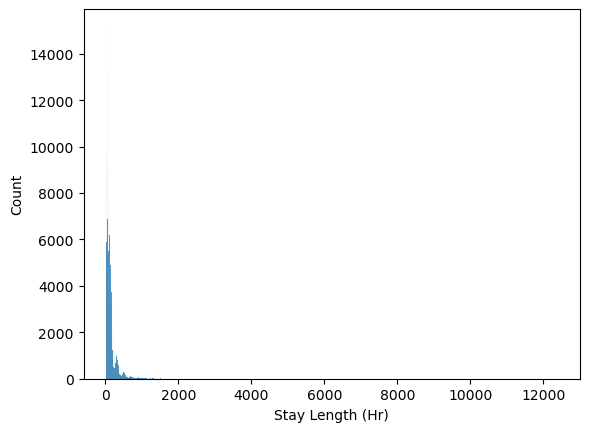

In [25]:
sns.histplot(data["stay_length"])
plt.xlabel("Stay Length (Hr)")
plt.show()

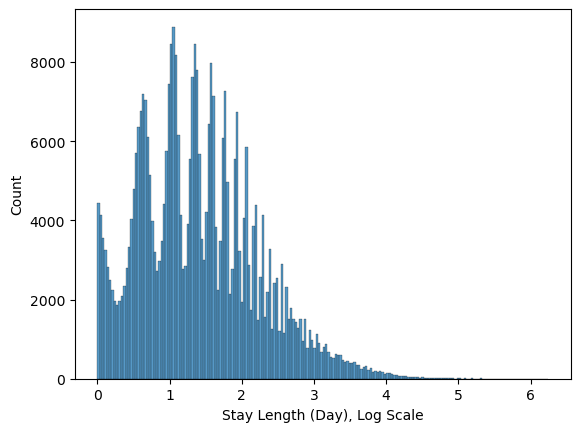

In [26]:
sns.histplot(np.log(data["stay_length"]/24))
plt.xlabel("Stay Length (Day), Log Scale")
plt.show()

Here we can observe strong right skewness. Statistically they are outliers, however, this number has it's reasonable meaning and cannot be simply discarded. Here we change the org hour based scale into a day based scale and do the log transformation to help with the distribution issue.

In [27]:
final["log_stay_day"] = np.log(data["stay_length"]/24)

###### Admission Year

We include this because health care quality may change from time to time.

In [28]:
final["admit_year"] = data["admittime"].str.split("-").str[0].astype(int)

In [29]:
final[final["admit_year"].isna()]

,subject_id,hadm_id,label,log_stay_day,admit_year


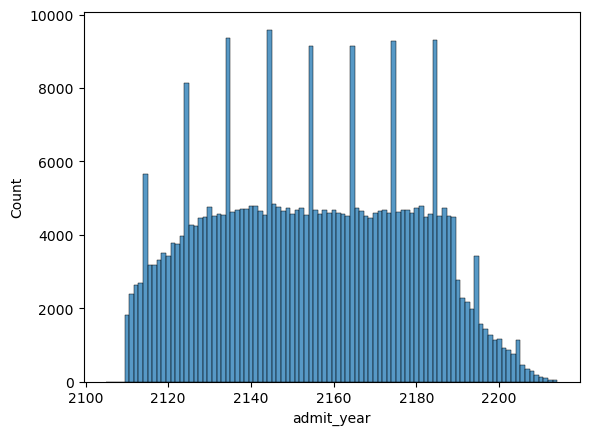

In [30]:
sns.histplot(final["admit_year"])
plt.show()

###### Gender and Age

We include this as gender and age can impact the disease severity.

In [31]:
index = final.index
final = final.merge(patient, on="subject_id", how="left").drop(["anchor_year_group","dod"], axis=1)
final.index = index

In [32]:
final["age"] = final["admit_year"] - final["anchor_year"] + final["anchor_age"]

In [33]:
final.drop(["anchor_year", "anchor_age"], axis=1, inplace=True)

In [34]:
final[final["age"].isna()]

,subject_id,hadm_id,label,log_stay_day,admit_year,gender,age


In [35]:
final[final["gender"].isna()]

,subject_id,hadm_id,label,log_stay_day,admit_year,gender,age


Here we discard `dod` as when we are in parctical situation we never know `dod`.

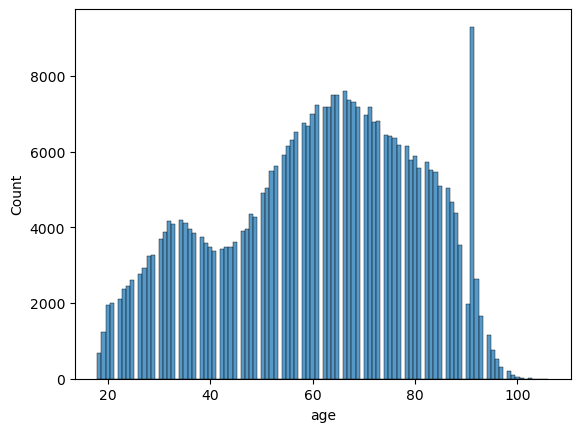

In [36]:
sns.histplot(final["age"])
plt.show()

In [37]:
patient["anchor_age"].max()

91

In [38]:
patient[patient["anchor_age"] == 91]

,subject_id,gender,anchor_age,anchor_year,anchor_year_group,dod
135,10003417,M,91,2111,2020 - 2022,NaN
143,10003757,F,91,2142,2017 - 2019,2143-05-02
311,10008408,M,91,2172,2014 - 2016,2173-05-14
354,10009585,M,91,2111,2011 - 2013,2111-08-29
408,10010956,F,91,2136,2017 - 2019,NaN
...,...,...,...,...,...,...
364410,19994020,M,91,2132,2020 - 2022,NaN
364441,19994873,M,91,2160,2017 - 2019,2160-05-04
364475,19995732,F,91,2115,2008 - 2010,NaN
364565,19997967,F,91,2158,2020 - 2022,NaN


Seems like the age was truncated after 91. We don't have method to rescue it, let it be then.

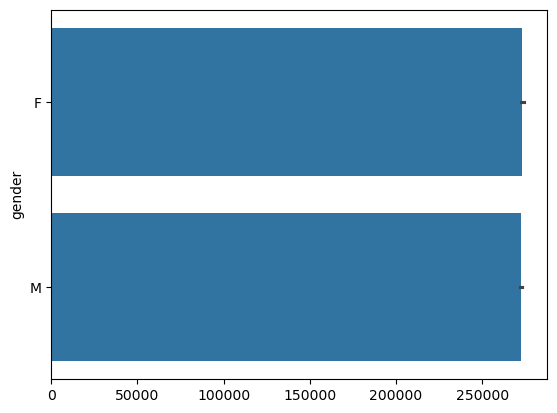

In [39]:
sns.barplot(final["gender"])
plt.show()

###### Admission type

We include this as this is related to disease severity.

In [40]:
final["admission_type"] = data["admission_type"]

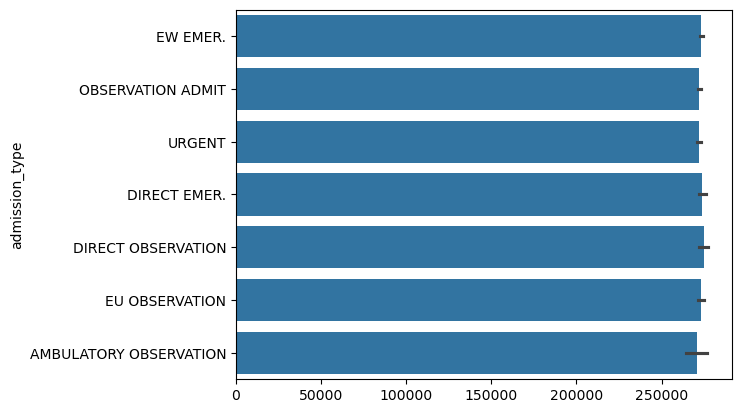

In [41]:
sns.barplot(final["admission_type"])
plt.show()

###### Insurance

We include as this may impact treatment activism.

In [42]:
final["insurance"] = data["insurance"]

In [43]:
final[final["insurance"].isna()]

,subject_id,hadm_id,label,log_stay_day,admit_year,gender,age,admission_type,insurance
343,10005606,29646384,0,2.363602,2143,M,38,URGENT,NaN
376,10006131,21367824,0,1.781990,2143,M,45,DIRECT EMER.,NaN
377,10006131,27849136,0,0.962697,2143,M,45,EW EMER.,NaN
436,10007134,29356606,0,0.937182,2140,M,51,OBSERVATION ADMIT,NaN
559,10009711,23299685,0,2.378710,2154,M,64,EW EMER.,NaN
...,...,...,...,...,...,...,...,...,...
545498,19990889,27221824,0,1.271437,2189,F,31,URGENT,NaN
545700,19994247,21395815,0,1.341922,2136,F,28,OBSERVATION ADMIT,NaN
545701,19994247,26230901,0,1.125110,2136,F,28,EU OBSERVATION,NaN
545813,19996464,22067120,0,0.381097,2167,M,24,EW EMER.,NaN


In [44]:
final["insurance"].unique()

array(['Medicaid', 'Medicare', 'Private', 'Other', nan, 'No charge'],
      dtype=object)

Here we have to impute the missing value. For subject without any insurance record, we impute as `No insurance` and for those with insurance record, we use the most frequent value to impute.

In [45]:
imputer = SimpleImputer(strategy="most_frequent")
for i,tmp_df in tqdm(final.groupby("subject_id")):
    missing_num = tmp_df["insurance"].isna().sum()
    # donot have missing
    if  missing_num == 0:
        continue
    # partial missing
    if missing_num != len(tmp_df):
        final.loc[tmp_df.index, "insurance"] = imputer.fit_transform(tmp_df[["insurance"]])
    # all missing
    else:
        final.loc[tmp_df.index, "insurance"] = "No insurance"

100%|██████████| 171486/171486 [00:13<00:00, 12644.28it/s]


In [46]:
final[final["insurance"].isna()]

,subject_id,hadm_id,label,log_stay_day,admit_year,gender,age,admission_type,insurance


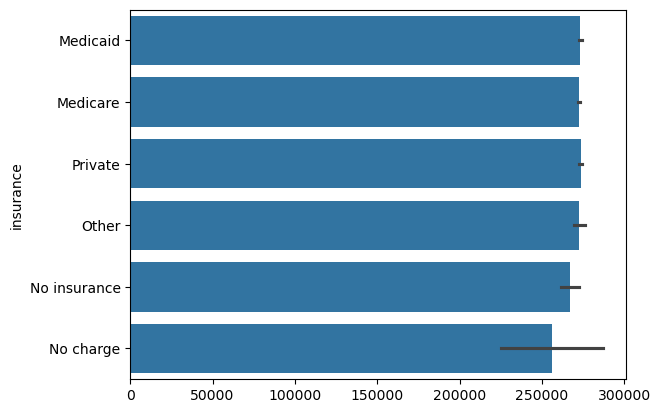

In [47]:
sns.barplot(final["insurance"])
plt.show()

###### Language and Race

We include language as language may hinder communication. We include race as it's related to different physical status of patients and potential discrimination.

In [48]:
final[["language", "race"]] = data[["language", "race"]]

In [49]:
final[final["race"].isna()]

,subject_id,hadm_id,label,log_stay_day,admit_year,gender,age,admission_type,insurance,language,race


In [50]:
final["race"].unique()

array(['WHITE', 'BLACK/AFRICAN AMERICAN', 'OTHER', 'UNKNOWN',
       'WHITE - RUSSIAN', 'BLACK/CAPE VERDEAN',
       'NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER', 'PORTUGUESE',
       'WHITE - OTHER EUROPEAN', 'ASIAN - CHINESE',
       'HISPANIC/LATINO - DOMINICAN', 'HISPANIC/LATINO - SALVADORAN',
       'UNABLE TO OBTAIN', 'HISPANIC/LATINO - PUERTO RICAN',
       'BLACK/AFRICAN', 'HISPANIC/LATINO - GUATEMALAN',
       'ASIAN - SOUTH EAST ASIAN', 'ASIAN', 'WHITE - BRAZILIAN',
       'HISPANIC OR LATINO', 'ASIAN - KOREAN', 'BLACK/CARIBBEAN ISLAND',
       'HISPANIC/LATINO - MEXICAN', 'PATIENT DECLINED TO ANSWER',
       'HISPANIC/LATINO - CUBAN', 'AMERICAN INDIAN/ALASKA NATIVE',
       'WHITE - EASTERN EUROPEAN', 'HISPANIC/LATINO - HONDURAN',
       'MULTIPLE RACE/ETHNICITY', 'HISPANIC/LATINO - CENTRAL AMERICAN',
       'ASIAN - ASIAN INDIAN', 'HISPANIC/LATINO - COLUMBIAN',
       'SOUTH AMERICAN'], dtype=object)

In [51]:
final[final["language"].isna()]

,subject_id,hadm_id,label,log_stay_day,admit_year,gender,age,admission_type,insurance,language,race
597,10010424,28388172,0,1.090477,2164,M,63,EW EMER.,Private,NaN,UNABLE TO OBTAIN
2767,10051939,29623973,1,1.245195,2112,F,91,EW EMER.,Medicare,NaN,WHITE
3665,10071605,21911997,0,0.661040,2156,F,39,URGENT,Private,NaN,WHITE
6424,10125865,23139194,0,2.716854,2158,F,48,URGENT,Medicaid,NaN,WHITE
6425,10125865,29695033,0,2.272985,2158,F,48,URGENT,Medicaid,NaN,WHITE
...,...,...,...,...,...,...,...,...,...,...,...
541660,19919835,28212691,0,0.949081,2133,F,29,URGENT,Medicaid,NaN,ASIAN
543448,19952742,29264490,0,1.418244,2149,M,57,DIRECT EMER.,Private,NaN,WHITE
545066,19984259,20109446,0,2.166033,2153,F,60,URGENT,Private,NaN,WHITE
545068,19984259,26869546,0,2.825586,2153,F,60,EW EMER.,Private,NaN,WHITE


In [52]:
final["language"].unique()

array(['English', 'Other', 'Russian', 'Kabuverdianu', 'Spanish',
       'American Sign Language', 'Vietnamese', 'Portuguese', nan,
       'Modern Greek (1453-)', 'Haitian', 'Persian', 'French', 'Chinese',
       'Arabic', 'Khmer', 'Japanese', 'Thai', 'Polish', 'Italian',
       'Amharic', 'Korean', 'Hindi', 'Bengali', 'Armenian', 'Somali'],
      dtype=object)

In [53]:
for i,tmp_df in tqdm(final.groupby("subject_id")):
    missing_num = tmp_df["language"].isna().sum()
    # donot have missing
    if  missing_num == 0:
        continue
    # partial missing
    if missing_num != len(tmp_df):
        print(i)

100%|██████████| 171486/171486 [00:09<00:00, 18645.54it/s]


Here the language is different from insurance as once we don't have language info for one subject. Here we simply put `UNKNOWN`

In [54]:
final.loc[final["language"].isna(), "language"] = "UNKNOWN"

In [55]:
final[final["language"].isna()]

,subject_id,hadm_id,label,log_stay_day,admit_year,gender,age,admission_type,insurance,language,race


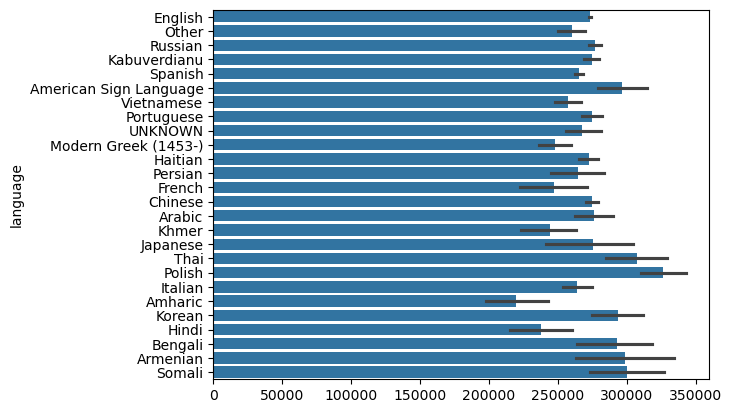

In [56]:
sns.barplot(final["language"])
plt.show()

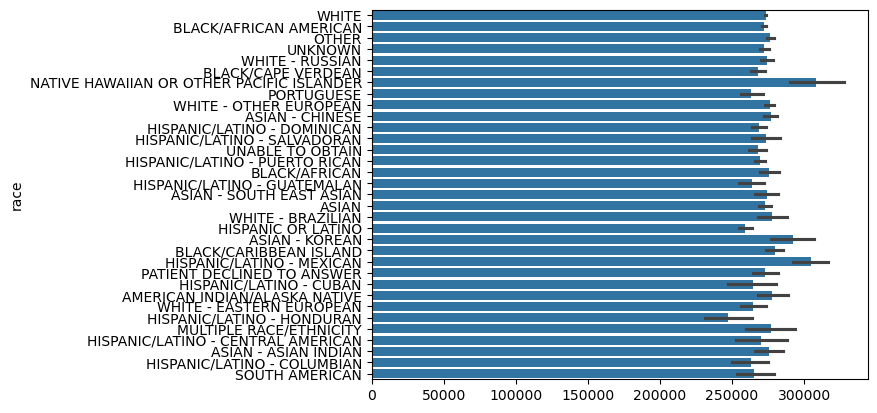

In [64]:
sns.barplot(final["race"])
plt.show()

##### Remove repeated measure

In [57]:
final = final[['subject_id', 'label', 'log_stay_day', 'admit_year',
       'gender', 'age', 'admission_type', 'insurance', 'language', 'race']].drop_duplicates()
final

,subject_id,label,log_stay_day,admit_year,gender,age,admission_type,insurance,language,race
1,10000032,0,0.015162,2180,F,52,EW EMER.,Medicaid,English,WHITE
2,10000032,0,0.561994,2180,F,52,EW EMER.,Medicaid,English,WHITE
3,10000032,0,0.798508,2180,F,52,EW EMER.,Medicaid,English,WHITE
5,10000084,0,1.512682,2160,M,72,EW EMER.,Medicare,English,WHITE
9,10000117,0,1.075192,2183,F,57,OBSERVATION ADMIT,Medicaid,English,WHITE
...,...,...,...,...,...,...,...,...,...,...
546023,19999828,0,2.303696,2149,F,48,EW EMER.,Medicaid,English,WHITE
546024,19999828,0,2.837575,2147,F,46,EW EMER.,Medicaid,English,WHITE
546025,19999840,1,1.945414,2164,M,58,EW EMER.,Private,English,WHITE
546026,19999840,0,1.250379,2164,M,58,EW EMER.,Private,English,WHITE


In [58]:
final.to_csv("./data/processed_mimic_sample.csv")

##### Label Prevalence

In [66]:
(final["label"] == 1).mean()

0.026424291388944993

##### Train, Valid, Test Split

Here, to prevent potential leakage, when we are doing the split, we make sure different entries of one specific subject is not distributed in different dataset. We leave out ~20% untouched test data to do the final evaluation and for the rest ~80% data, we do 5-fold cross validation for tuning the hyperparameters. Given the low prevalence, we explictly make sure some positive samples are included in the three sets.

In [98]:
def split_sanity_check(df1, df2):
    print("df1 positive label num:", df1['label'].sum())
    print("df1 sample percentage:", len(df1) / (len(df1) + len(df2)))
    print()
    print("df2 positive label num:", df2['label'].sum())
    print("df2 sample percentage:", len(df2) / (len(df1) + len(df2)))
    print()
    print("Subject intersection:", set(df1["subject_id"]).intersection(set(df2["subject_id"])))

In [94]:
subject_labels = final.groupby('subject_id')['label'].max().reset_index()
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(sss.split(subject_labels['subject_id'], subject_labels['label']))

train_subjects = subject_labels.iloc[train_idx]['subject_id']
test_subjects = subject_labels.iloc[test_idx]['subject_id']

train_df = final[final['subject_id'].isin(train_subjects)].copy()
test_df = final[final['subject_id'].isin(test_subjects)].copy()

In [99]:
split_sanity_check(train_df, test_df)

df1 positive label num: 7850
df1 sample percentage: 0.7983518481114926

df2 positive label num: 1962
df2 sample percentage: 0.20164815188850738

Subject intersection: set()


#### [15 Points] Question 2.2: Model Selection and Hyperparameter Tuning

Perform model selection and hyperparameter tune your models (again--we're not being prescriptive here). Justify your experimentation decisions, including choice of model type, metric to optimize for, etc.

<font color="red">Answer 2.2</font>

We need to deal with the label imbalance and we need robust predictive performance.

Here, we choose boosting model as the estimator, `HistGradientBoostingClassifier` in particular, for its efficiency and scalability, especially when handling large datasets. What's more, boosting methods are well-known for it's robust performance on tabular data and they can also model non-linear relationship, which is essential for modeling complicated real world data.

To deal with label imbalance, we optimize for PRAUC, which is effective in scenarios where the positive class is rare. What's more, generally speaking, in this task, the most important task is to improve precision.

For the model tuning, since the model adopts early stop, we donot need to tune the max iter. The parameters are generally used for controlling model complexity (`max_leaf_nodes`, `min_samples_leaf`, `l2_regularization`).

In [127]:
num_features = ['log_stay_day', 'admit_year', 'age']
cat_features = ['gender', 'admission_type', 'insurance', 'language', 'race']

cv = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=42)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_features),
        ('cat', OrdinalEncoder(), cat_features)
    ]
)

In [132]:
X = preprocessor.fit_transform(train_df.iloc[:, 2:])
y = train_df['label']
groups = train_df['subject_id']

params = {
    'max_depth': np.arange(3, 11),
    'learning_rate': np.linspace(0.01, 0.2, 20),
    'max_leaf_nodes': np.arange(10, 101, 10),
    'min_samples_leaf': np.arange(5, 51, 5),
    'l2_regularization': np.linspace(0, 1.0, 11),
}

In [133]:
model = HistGradientBoostingClassifier(random_state=42)

In [136]:
search = RandomizedSearchCV(
    estimator=model,
    param_distributions=params,
    n_iter=50,
    scoring='average_precision',
    cv=cv, 
    random_state=42,
    verbose=1,
    n_jobs=-1
)

In [137]:
search.fit(X, y, groups=groups)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


RandomizedSearchCV(cv=StratifiedGroupKFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=HistGradientBoostingClassifier(random_state=42),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'l2_regularization': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
                                        'learning_rate': array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11,
       0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 ]),
                                        'max_depth': array([ 3,  4,  5,  6,  7,  8,  9, 10]),
                                        'max_leaf_nodes': array([ 10,  20,  30,  40,  50,  60,  70,  80,  90, 100]),
                                        'min_samples_leaf': array([ 5, 10, 15, 20, 25, 30, 35, 40, 45, 50])},
                   random_state=42, scoring='average_precision', verbose=1)


#### [10 Points] Question 2.3: Train and Evaluate your Best Model and Report Classification Metrics

As always, report [distributional information for your classification metrics](https://aaai.org/conference/aaai/aaai-25/aaai-25-reproducibility-checklist/).

In [141]:
def bootstrap_test_from_pred(label, pred_prob, bootstrap_num=200, bootstrap_sample_size=1000, **kwargs):
    assert pred_prob.shape[0] == label.shape[0]

    pred = np.argmax(pred_prob, axis = 1)
    idx = np.arange(label.shape[0])

    metric_dict = {k:[] for k in kwargs.keys()}

    for i in range(bootstrap_num):
        bootstrap_sample_idx = np.random.RandomState(seed=i).choice(idx, size=bootstrap_sample_size, replace=True)
        bootstrap_label = label[bootstrap_sample_idx]
        bootstrap_pred = pred[bootstrap_sample_idx]
        bootstrap_pred_prob = pred_prob[bootstrap_sample_idx, :]

        for metric, func in kwargs.items():
            if "AUC" in metric:
                metric_dict[metric].append(func(bootstrap_label, bootstrap_pred_prob[:,1]))
            else:
                metric_dict[metric].append(func(bootstrap_label, bootstrap_pred))
    
    return metric_dict

In [138]:
best_model = search.best_estimator_

In [139]:
test_X = preprocessor.transform(test_df.iloc[:, 2:])

In [151]:
predicted_probs = best_model.predict_proba(test_X)

In [154]:
test_metrics = bootstrap_test_from_pred(label=test_df["label"].values, pred_prob=predicted_probs, bootstrap_sample_size=len(test_df), PRAUC=average_precision_score, ROAUC=roc_auc_score, Accuracy=accuracy_score, Recall=recall_score, Precision=precision_score, F1=f1_score)

In [155]:
method_name = "Boosting"
print(f"Bootstrap Metrics Evaluation for {method_name}\n")
for metric, metric_res in test_metrics.items():
    print(f"{metric}:")
    print(f"Mean: {np.mean(metric_res):.3f}")
    print(f"95% CI Upper: {np.percentile(metric_res, 97.5):.3f}")
    print(f"95% CI Lower: {np.percentile(metric_res, 2.5):.3f}")
    print("*"*15)

Bootstrap Metrics Evaluation for Boosting

PRAUC:
Mean: 0.138
95% CI Upper: 0.151
95% CI Lower: 0.125
***************
ROAUC:
Mean: 0.824
95% CI Upper: 0.832
95% CI Lower: 0.816
***************
Accuracy:
Mean: 0.974
95% CI Upper: 0.975
95% CI Lower: 0.973
***************
Recall:
Mean: 0.014
95% CI Upper: 0.019
95% CI Lower: 0.009
***************
Precision:
Mean: 0.661
95% CI Upper: 0.796
95% CI Lower: 0.500
***************
F1:
Mean: 0.027
95% CI Upper: 0.037
95% CI Lower: 0.019
***************


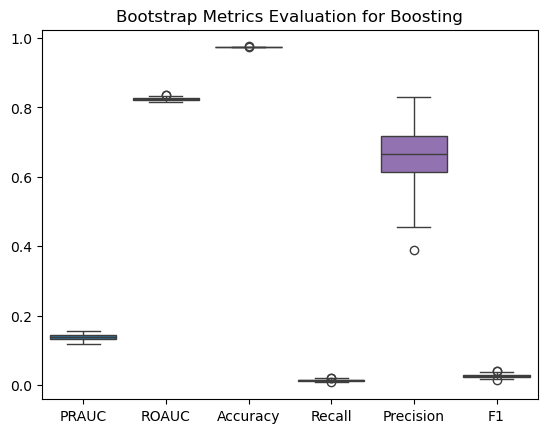

In [156]:
sns.boxplot(data=pd.DataFrame(test_metrics).melt(var_name="Metrics"), x="Metrics", y="value", hue="Metrics")
plt.xlabel(None)
plt.ylabel(None)
plt.title(f"Bootstrap Metrics Evaluation for {method_name}")
plt.show()

#### [5 Points] Question 2.4: Propose Methods to Improve the Utility of your Model

This could be from the modelling standpoint (i.e. "how can we improve classification performance?"), robustness across settings (i.e. "how can we ensure a model trained with BIDMC data works works on data at NY-P?") or from a deployment standpoint (i.e. "how can we make this model useful for clinicians?").

<font color="red">Answer 2.4</font>

1. Improve feature engineering. For traditional machine learning models, feature engineering is the most important part for model performance. However, this usually needs incorporating strong domain knowledge, including choosing the important feature, feature transformation, feature imputation, etc. Here, we lack that expertise.
2. Try to incorporate more positive samples in the data. The prevalence is really low in this dataset, making it really hard for the model to learn information of positive labels. Downsampling the negative samples may be a way to avoid this kind of imbalance. Another way may be trying to incorporate pesudo positive labels.
3. Here we independently model different entries of the same individual. We may need to reconsider this hypothesis and include the time dependency into our feature.
4. To make the model more useful to clinicians, we may need to further collect features that can be measured real-time so that clinicans can monitor the probability in real-time. Also we may want our model to be more interpretable.